## Classification ML pipeline (low/medium/high).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
from rasterstats import zonal_stats
import fiona
from rasterio.plot import show
from rasterio.mask import mask
import rasterstats
import shapely.geometry as geom
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
restoration_dataset = gpd.read_file("../outputs/restoration_score_dataset.gpkg")

In [6]:
restoration_dataset.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 29955 entries, 0 to 29954
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fire_id            29955 non-null  object        
 1   fire_year          29955 non-null  int64         
 2   fire_month         29955 non-null  int64         
 3   fire_day           29955 non-null  int64         
 4   fire_rep_date      29955 non-null  datetime64[ms]
 5   fire_size_ha       29955 non-null  float64       
 6   fire_calc_ha       29955 non-null  float64       
 7   fire_cause         29955 non-null  object        
 8   fire_map_method    29935 non-null  object        
 9   fire_poly_date     28660 non-null  datetime64[ms]
 10  climate_index      29955 non-null  int64         
 11  dist_to_station    29955 non-null  float64       
 12  dist_roads         29955 non-null  float64       
 13  overlap_pct        29955 non-null  float64       
 14

### Creating the feature for classification focus 
| __Priority_class__ |

In [7]:
# Bin restoration_score into 3 quantile-based classes
restoration_dataset["priority_class"] = pd.qcut(
    restoration_dataset["restoration_score"],
    q=3,
    labels=["Low", "Medium", "High"]
)

# Quick check of class distribution
print(restoration_dataset["priority_class"].value_counts())


priority_class
Low       6785
High      6783
Medium    6781
Name: count, dtype: int64


### Fixing features with NaN

In [8]:
restoration_dataset.isnull().sum()[restoration_dataset.isnull().sum() > 0]


fire_map_method        20
fire_poly_date       1295
elevation_mean         16
elevation_min          16
elevation_max          16
elevation_std          16
burnsev_min          6858
burnsev_max          6858
burnsev_mean         6858
burnsev_std          6858
climate_P            3896
climate_score        3896
restoration_score    9606
priority_class       9606
dtype: int64

__Dropping__ and __inputing__ data points that doesn't have classifications

* Filling with median
* Using SimpleImputer  

In [9]:
restoration_dataset = restoration_dataset.dropna(subset=["priority_class"])


Selecting the features

In [10]:
features = [
    "fire_size_sqm", "fire_calc_sqm",
    "dist_to_station", "dist_roads", "overlap_pct", "dist_community",
    "elevation_mean", "elevation_std",
    "burnsev_min", "burnsev_max", "burnsev_mean", "burnsev_std",
    "climate_Tm", "climate_Tx", "climate_Tn", "climate_P",
    "climate_S", "climate_SG", "climate_RH",
    "land_cover_score", "climate_score"
]

X = restoration_dataset[features]
y = restoration_dataset["priority_class"]


Train/test split

In [11]:
from sklearn.model_selection import train_test_split

X = restoration_dataset[features]
y = restoration_dataset["priority_class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (16279, 21) Test shape: (4070, 21)


Scaling - StandardScaler

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Fitting the classifier

In [13]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)

rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

        High       0.97      0.97      0.97      1357
         Low       0.96      0.97      0.96      1357
      Medium       0.94      0.93      0.94      1356

    accuracy                           0.96      4070
   macro avg       0.96      0.96      0.96      4070
weighted avg       0.96      0.96      0.96      4070

Confusion Matrix:
[[1317    2   38]
 [   1 1319   37]
 [  38   60 1258]]


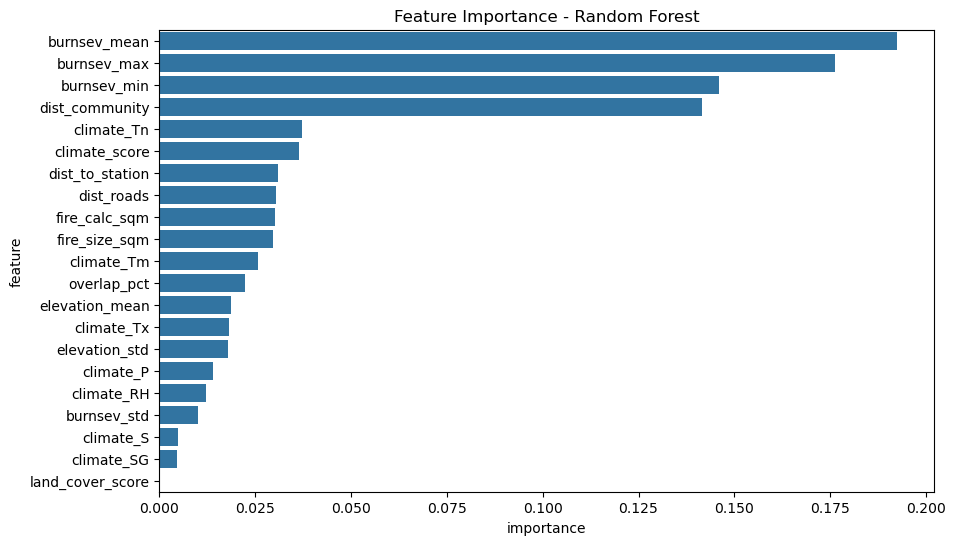

In [14]:
# Train a baseline Random Forest
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_imp_df = feat_imp_df.sort_values(by="importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feat_imp_df)
plt.title("Feature Importance - Random Forest")
plt.show()


#### Hyperparameter tuning

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring="f1_macro"
)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
best_rf = grid_search.best_estimator_


Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [16]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring="f1_macro")
print("CV F1-macro scores:", cv_scores)
print("Mean CV F1-macro:", cv_scores.mean())

CV F1-macro scores: [0.950191   0.95485655 0.95260913 0.9484834  0.95026329]
Mean CV F1-macro: 0.9512806700835682


#### Spatial distribution of __predicted restoration priority areas__

* (High, Medium, Low) across British Columbia

In [17]:
restoration_dataset.columns

Index(['fire_id', 'fire_year', 'fire_month', 'fire_day', 'fire_rep_date',
       'fire_size_ha', 'fire_calc_ha', 'fire_cause', 'fire_map_method',
       'fire_poly_date', 'climate_index', 'dist_to_station', 'dist_roads',
       'overlap_pct', 'dist_community', 'elevation_mean', 'elevation_min',
       'elevation_max', 'elevation_std', 'burnsev_min', 'burnsev_max',
       'burnsev_mean', 'burnsev_std', 'climate_Tm', 'climate_Tx', 'climate_Tn',
       'climate_P', 'climate_S', 'climate_SG', 'climate_year', 'climate_month',
       'climate_long', 'climate_lat', 'climate_RH', 'land_cover_class',
       'fire_size_sqm', 'fire_calc_sqm', 'land_cover_score', 'climate_score',
       'restoration_score', 'geometry', 'priority_class'],
      dtype='object')

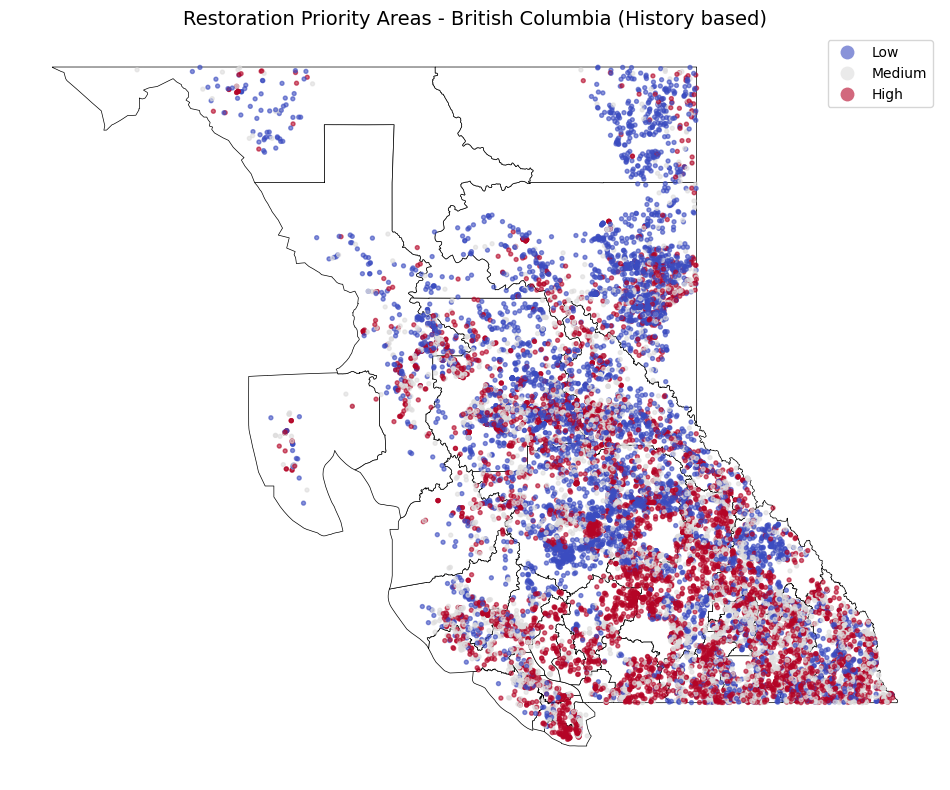

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load BC census divisions
bc_divisions = gpd.read_file("../data_raw/bc_boundaries/CEN_CENSUS_DIVISIONS_SVW.geojson")

# Ensure CRS (coordinate reference system) matches
if restoration_dataset.crs != bc_divisions.crs:
    restoration_dataset = restoration_dataset.to_crs(bc_divisions.crs)

# Plot
fig, ax = plt.subplots(figsize=(12, 14))

# Plot BC boundaries
bc_divisions.plot(ax=ax, color="white", edgecolor="black", linewidth=0.5)

# Plot predicted restoration priorities
restoration_dataset.plot(
    column="priority_class",
    cmap="coolwarm",
    legend=True,
    ax=ax,
    markersize=8,
    alpha=0.6
)

plt.title("Restoration Priority Areas - British Columbia (History based)", fontsize=14)
plt.axis("off")
plt.show()


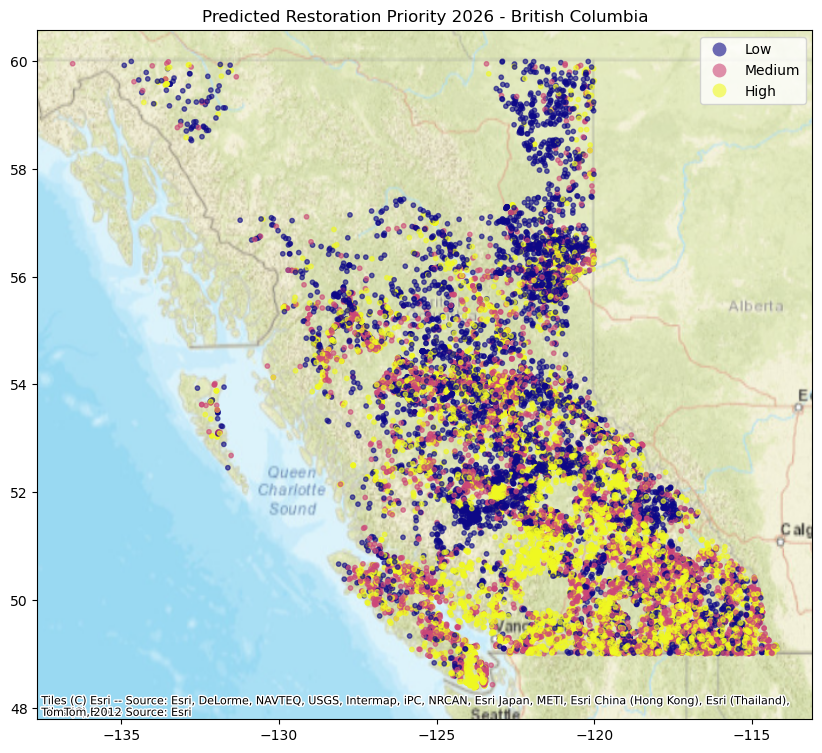

In [30]:
import contextily as ctx

# OpenStreetMap default
ctx.providers.OpenStreetMap.Mapnik

# ESRI World Imagery (satellite)
ctx.providers.Esri.WorldImagery

# ESRI Terrain
ctx.providers.Esri.WorldShadedRelief


fig, ax = plt.subplots(figsize=(10, 12))

restoration_dataset.plot(
    column="priority_class",
    cmap="plasma",
    legend=True,
    ax=ax,
    markersize=10,
    alpha=0.6
)

# Add ESRI terrain + labels
ctx.add_basemap(
    ax,
    crs=restoration_dataset.crs,
    source=ctx.providers.Esri.WorldShadedRelief
)

ctx.add_basemap(
    ax,
    crs=restoration_dataset.crs,
    source=ctx.providers.Esri.WorldStreetMap
)

plt.title("Predicted Restoration Priority 2026 - British Columbia")
plt.show()



In [20]:
restoration_dataset.columns

Index(['fire_id', 'fire_year', 'fire_month', 'fire_day', 'fire_rep_date',
       'fire_size_ha', 'fire_calc_ha', 'fire_cause', 'fire_map_method',
       'fire_poly_date', 'climate_index', 'dist_to_station', 'dist_roads',
       'overlap_pct', 'dist_community', 'elevation_mean', 'elevation_min',
       'elevation_max', 'elevation_std', 'burnsev_min', 'burnsev_max',
       'burnsev_mean', 'burnsev_std', 'climate_Tm', 'climate_Tx', 'climate_Tn',
       'climate_P', 'climate_S', 'climate_SG', 'climate_year', 'climate_month',
       'climate_long', 'climate_lat', 'climate_RH', 'land_cover_class',
       'fire_size_sqm', 'fire_calc_sqm', 'land_cover_score', 'climate_score',
       'restoration_score', 'geometry', 'priority_class'],
      dtype='object')

C:\Users\Dell\AppData\Local\Temp\ipykernel_19664\3118693904.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_per_year = restoration_dataset.groupby(["fire_year", "priority_class"]).size().reset_index(name="count")


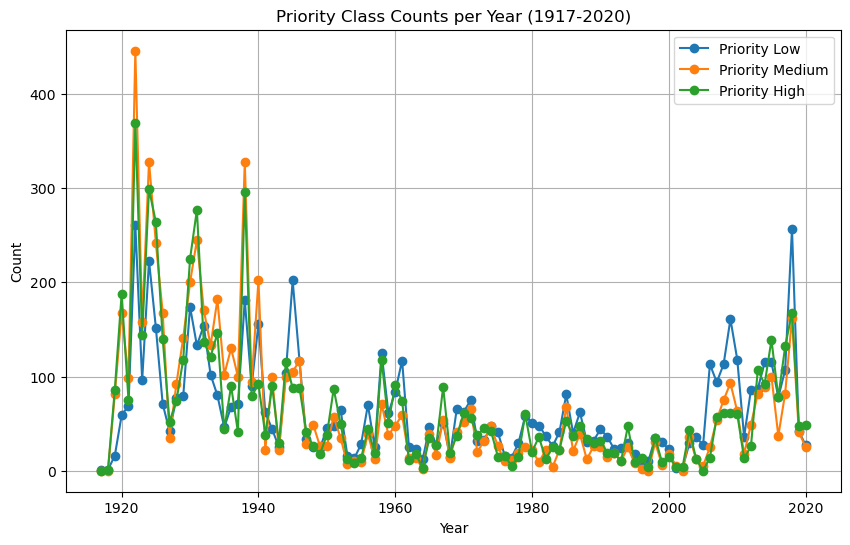

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is called df
# and it has columns: 'year' and 'priority_class'

# --- 1. Priority class numbers per year ---
counts_per_year = restoration_dataset.groupby(["fire_year", "priority_class"]).size().reset_index(name="count")

plt.figure(figsize=(10,6))
for pc in counts_per_year["priority_class"].unique():
    subset = counts_per_year[counts_per_year["priority_class"] == pc]
    plt.plot(subset["fire_year"], subset["count"], marker="o", label=f"Priority {pc}")

plt.title("Priority Class Counts per Year (1917-2020)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()


Predictions for 2026

In [22]:
counts_per_year = restoration_dataset.groupby(["fire_year", "priority_class"]).size().reset_index(name="count")


C:\Users\Dell\AppData\Local\Temp\ipykernel_19664\328343119.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_per_year = restoration_dataset.groupby(["fire_year", "priority_class"]).size().reset_index(name="count")


C:\Users\Dell\AppData\Local\Temp\ipykernel_19664\1526434255.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_per_year = restoration_dataset.groupby(["fire_year", "priority_class"]).size().reset_index(name="count")


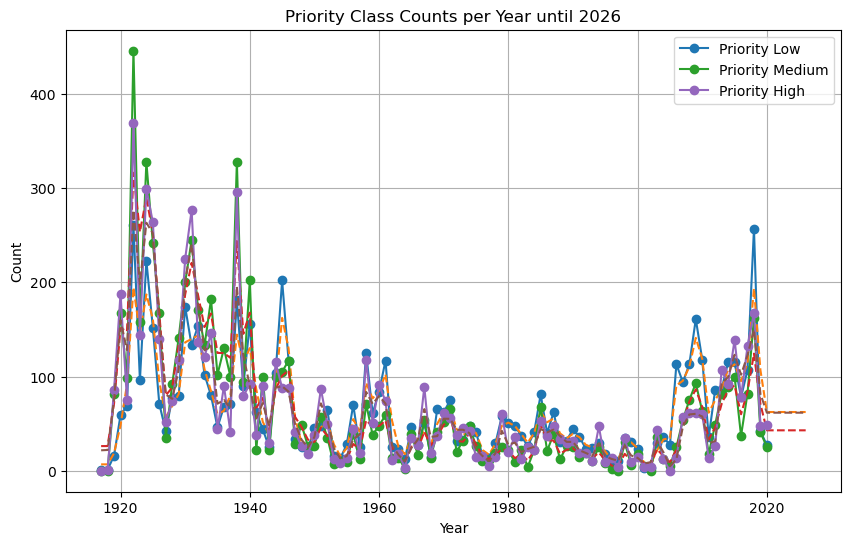

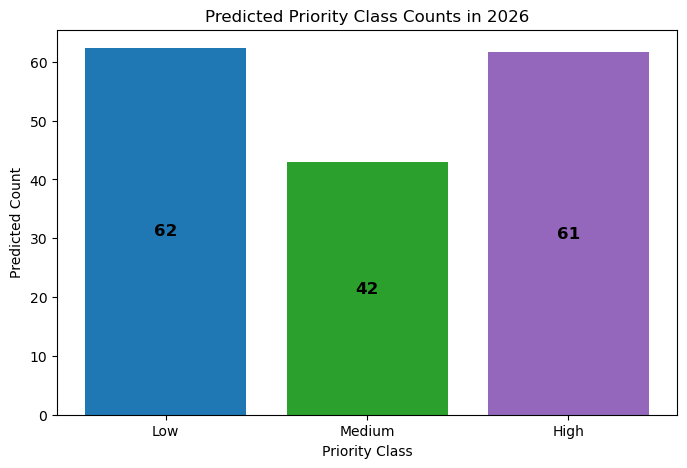

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor as RandomForest
from sklearn.linear_model import LinearRegression
import numpy as np

# Aggregate counts per year & priority class
counts_per_year = restoration_dataset.groupby(["fire_year", "priority_class"]).size().reset_index(name="count")

# Prepare future year for prediction
future_year = 2026

predictions = []

plt.figure(figsize=(10,6))

for pc in counts_per_year["priority_class"].unique():
    subset = counts_per_year[counts_per_year["priority_class"] == pc]

    X = subset["fire_year"].values.reshape(-1,1)
    y = subset["count"].values

    model = RandomForest()
    model.fit(X, y)

    # Predict 2026
    pred = model.predict(np.array([[future_year]]))[0]
    predictions.append((pc, pred))

    # Plot actual trend
    plt.plot(subset["fire_year"], y, marker="o", label=f"Priority {pc}")

    # Plot regression line
    years_range = np.arange(subset["fire_year"].min(), future_year+1).reshape(-1,1)
    plt.plot(years_range, model.predict(years_range), linestyle="--")

plt.title("Priority Class Counts per Year until 2026")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

# --- Bar chart for 2026 prediction ---
pred_df = pd.DataFrame(predictions, columns=["priority_class", "predicted_count"])

plt.figure(figsize=(8,5))
bar_labels = ['blue', 'green', 'purple']
bar_colors = ['tab:blue', 'tab:green', 'tab:purple']
bars = plt.bar(pred_df["priority_class"], pred_df["predicted_count"],
                color=bar_colors, label=bar_labels)

# Add values inside each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position
        height / 2,                        # y position (middle of the bar)
        f"{int(height)}",                  # text (integer count)
        ha="center", va="center", color="black", fontsize=12, fontweight="bold"
    )

plt.title("Predicted Priority Class Counts in 2026")
plt.xlabel("Priority Class")
plt.ylabel("Predicted Count")
plt.show()


In [24]:
restoration_dataset.columns

Index(['fire_id', 'fire_year', 'fire_month', 'fire_day', 'fire_rep_date',
       'fire_size_ha', 'fire_calc_ha', 'fire_cause', 'fire_map_method',
       'fire_poly_date', 'climate_index', 'dist_to_station', 'dist_roads',
       'overlap_pct', 'dist_community', 'elevation_mean', 'elevation_min',
       'elevation_max', 'elevation_std', 'burnsev_min', 'burnsev_max',
       'burnsev_mean', 'burnsev_std', 'climate_Tm', 'climate_Tx', 'climate_Tn',
       'climate_P', 'climate_S', 'climate_SG', 'climate_year', 'climate_month',
       'climate_long', 'climate_lat', 'climate_RH', 'land_cover_class',
       'fire_size_sqm', 'fire_calc_sqm', 'land_cover_score', 'climate_score',
       'restoration_score', 'geometry', 'priority_class'],
      dtype='object')

MAP creation

In [25]:
# import folium

# # Step 1: Aggregate counts per geometry, year, and priority class
# counts_geom_year = (
#     restoration_dataset
#     .groupby(["geometry", "fire_year", "priority_class"])
#     .size()
#     .reset_index(name="count")
# )

# future_year = 2026
# predictions_map = []

# # Step 2: Train per geometry + priority class
# for (geom, pc), subset in counts_geom_year.groupby(["geometry", "priority_class"]):
#     X = subset["fire_year"].values.reshape(-1, 1)
#     y = subset["count"].values

#     if len(np.unique(y)) > 1:  # only train if variation exists
#         model = RandomForest(random_state=42)
#         model.fit(X, y)
#         pred = model.predict(np.array([[future_year]]))[0]
#     else:
#         pred = y.mean()  # fallback if flat counts

#     predictions_map.append({
#         "geometry": geom,
#         "priority_class": pc,
#         "predicted_count": pred
#     })

# pred_df_map = pd.DataFrame(predictions_map)

# # Step 3: Convert to GeoDataFrame (keeps geometries)
# pred_gdf_map = gpd.GeoDataFrame(pred_df_map, geometry="geometry", crs=restoration_dataset.crs)

# # Step 4: Folium map
# # Use centroid of geometry for marker placement
# m = folium.Map(
#     location=[
#         restoration_dataset.geometry.centroid.y.mean(),
#         restoration_dataset.geometry.centroid.x.mean()
#     ],
#     zoom_start=6,
#     tiles="cartodbpositron"
# )

# for _, row in pred_gdf_map.iterrows():
#     centroid = row["geometry"].centroid
#     folium.CircleMarker(
#         location=[centroid.y, centroid.x],
#         radius=max(3, row["predicted_count"] / 10),  # scale radius
#         color="red" if row["priority_class"] == 1 else "green" if row["priority_class"] == 2 else "purple",
#         fill=True,
#         fill_opacity=0.6,
#         popup=(f"Priority {row['priority_class']}<br>"
#                f"Predicted Count: {row['predicted_count']:.0f}")
#     ).add_to(m)

# m.save("predicted_priority_2026.html")

In [26]:
# restoration_dataset = restoration_dataset.to_crs(epsg=3005)

In [2]:
# restoration_dataset.to_csv("../outputs/restoration_score_dataset_final.csv", index=False)
restoration_dataset = pd.read_csv("../outputs/restoration_score_dataset_final.csv")
restoration_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20349 entries, 0 to 20348
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fire_id            20349 non-null  object 
 1   fire_year          20349 non-null  int64  
 2   fire_month         20349 non-null  int64  
 3   fire_day           20349 non-null  int64  
 4   fire_rep_date      20349 non-null  object 
 5   fire_size_ha       20349 non-null  float64
 6   fire_calc_ha       20349 non-null  float64
 7   fire_cause         20346 non-null  object 
 8   fire_map_method    20338 non-null  object 
 9   fire_poly_date     20045 non-null  object 
 10  climate_index      20349 non-null  int64  
 11  dist_to_station    20349 non-null  float64
 12  dist_roads         20349 non-null  float64
 13  overlap_pct        20349 non-null  float64
 14  dist_community     20349 non-null  float64
 15  elevation_mean     20349 non-null  float64
 16  elevation_min      203

In [28]:
# restoration_dataset["land_cover_class"].unique()